# Retinal Blood Vessels Segmentation
### `IABI Course, Dr. Rohban`
#### Homework 1
*`Full Name:`* Armin Khosravi

*`SID:`* 401105872

**Colleagues:**

- Alireza Malek Hosseini
- Pouya Esmaeili Akhoundi
- Ali Bakhtiari


## Proposed Method Description


In this notebook, we aim to extract suitable features using **image processing techniques**,
to obtain a **20-dimensional feature vector** for each pixel. Then, by using a **simple neural network**,
we train the model to learn these features. The goal is for the network to predict, for the **pixels in the test images**,
whether the pixels belong to **vessels** or the **background**.

<p align="left">
<img src="https://drive.usercontent.google.com/download?id=1wpOngGlh_wRui368o22RlfrzPOp7HZKq&export=download&authuser=0&confirm=t&uuid=ccc851a6-589d-47a1-94c5-75343b6e3427&at=AN_67v00Rdv1c_MovmsIyGdovxg6:1727563819162" alt="" width="500"/>
</p>

In [9]:
!pip install gdown

In [17]:
! gdown 1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte
! unzip DRIVE

Downloading...
From (original): https://drive.google.com/uc?id=1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte
From (redirected): https://drive.google.com/uc?id=1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte&confirm=t&uuid=c0fe461d-1316-48b2-8ccc-7a0f914cf152
To: /home/armin/D/Code/Python/NoteBooks/Notebooks/IABI /Rohban HW P/1/DRIVE.zip
100%|██████████████████████████████████████| 29.8M/29.8M [00:10<00:00, 2.82MB/s]
Archive:  DRIVE.zip
replace DRIVE/Test/1st_manual/01_manual1.gif? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [37]:
import cv2
import imageio
import numpy as np
import pandas as pd
from os import listdir
import scipy.ndimage as ndi
from typing import *
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from os.path import isfile, join
import skimage.measure
from skimage.morphology import disk
from scipy import ndimage
from tqdm import tqdm
import random

In [2]:
def plot_images(images: list[np.ndarray]):
    plt.figure(figsize=(16, 3))
    plt.imshow(
        np.hstack(images), cmap='gray'
    )
    plt.axis('off')
    plt.show()

In [3]:
def plot_images_without_cmap(images: list[np.ndarray]):
    plt.figure(figsize=(16, 3))
    plt.imshow(
        np.hstack(images)
    )
    plt.axis('off')
    plt.show()

**DRIVE Dataset Overview:**

In this notebook, the DRIVE dataset has been used, which contains two sets of images: train and test. Each set includes 20 retinal images. For each image, there is a corresponding mask that defines the region of the retina within the image.

The label associated with each image is a binary image where the vessels are represented by the value 255 and the background by the value 0.

Important: Pathological features related to each image are not specified in the dataset.

Note: The labels for the test images are provided by two specialists.

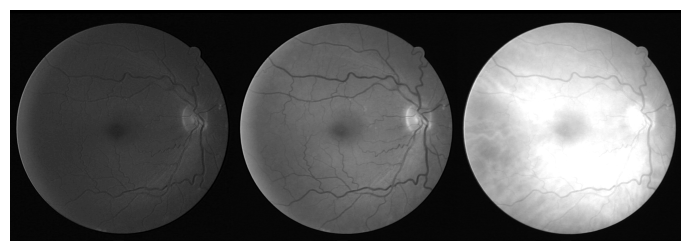

In [4]:
test_img = cv2.imread('DRIVE/Training/images/22_training.tif')
test_mask = np.array(imageio.mimread('DRIVE/Training/mask/22_training_mask.gif')).reshape(584, 565)

plot_images([test_img[:, :, 0], test_img[:, :, 1], test_img[:, :, 2]])

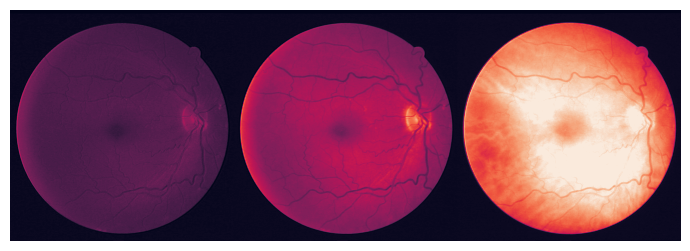

In [5]:
test_img = cv2.imread('DRIVE/Training/images/22_training.tif')
test_mask = np.array(imageio.mimread('DRIVE/Training/mask/22_training_mask.gif')).reshape(584, 565)

plot_images_without_cmap([test_img[:, :, 0], test_img[:, :, 1], test_img[:, :, 2]])

In [6]:
print(f'test_img shape : {test_img.shape}')
print(f'test_mask shape : {test_mask.shape}')


test_img shape : (584, 565, 3)
test_mask shape : (584, 565)


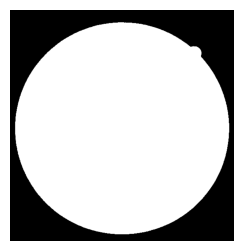

In [7]:
plot_images([test_mask])

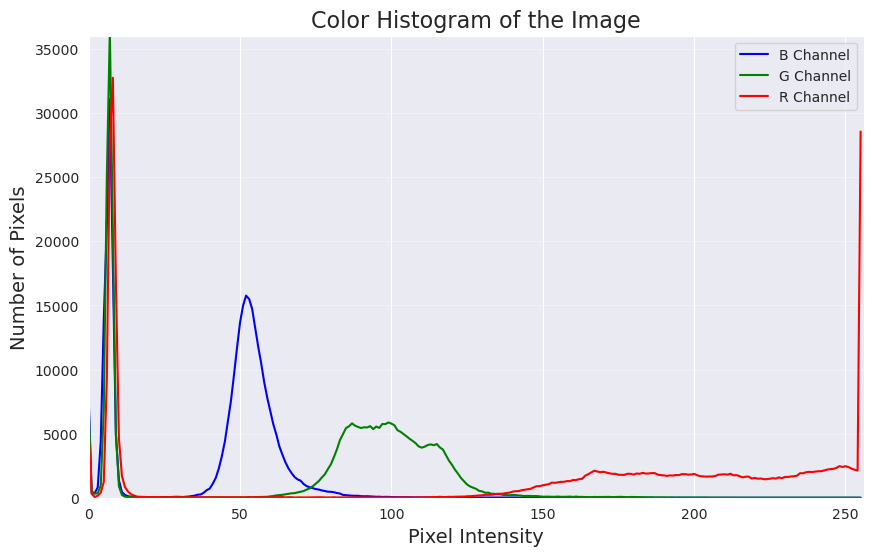

In [8]:
import cv2
import matplotlib.pyplot as plt

colors = ['b', 'g', 'r']
plt.figure(figsize=(10, 6))

for j, col in enumerate(colors):
    histogram_train0_c = cv2.calcHist([test_img], [j], None, [256], [0, 256])
    plt.plot(histogram_train0_c, color=col, label=f'{col.upper()} Channel')

plt.title('Color Histogram of the Image', fontsize=16)
plt.xlabel('Pixel Intensity', fontsize=14)
plt.ylabel('Number of Pixels', fontsize=14)
plt.xlim([0, 256])
plt.ylim([0, max(histogram_train0_c) * 1.1])
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.show()


You must select one of the red, green, or blue channels from the color image `(Explain your reasoning for the selection)`.

`Your response (2 pts):`

---

### Experimentally Proven Advantage of Green Light
**Experimentally, we show that the green channel is better for retinal blood vessel segmentation. In the chart, the green channel demonstrates higher intensity compared to the red and blue channels in Some Regions, indicating better contrast for blood vessels.** We only use one channel to reduce complexity in our analysis. This conclusion is supported by color histogram analysis, which indicates a higher contrast for green compared to red and blue channels based on visual representation in the chart. The theoretical basis for this preference is grounded in the interaction of different **wavelengths of light**, **hemoglobin**, and the retina's **photoreceptors**.

---

### Wavelengths of RGB Light
- **Blue Light** (~450-495 nm): This short wavelength scatters more due to interactions with the eye's optical components, such as the cornea and lens. The increased scattering leads to noise and blurring of details.

- **Green Light** (~495-570 nm): Green light is more balanced than the other wavelengths; it does not penetrate as deeply as red light nor scatter as much as blue light. This balance allows it to provide optimal contrast for visualizing blood vessels against the surrounding tissue.

- **Red Light** (~620-750 nm): Although red light penetrates deeper into biological tissues, this deeper penetration can obscure the visibility of superficial structures like blood vessels, making them harder to distinguish in imaging applications.

Overall, if the wavelength increases, penetration increases; however, if it decreases, scattering increases. This relationship significantly impacts the choice of light for imaging tasks.

---

### Interaction with Hemoglobin
Blood vessels are rich in **hemoglobin**, a protein in red blood cells that contains iron ions as part of its heme group. This structure gives hemoglobin distinct electronic properties that enable it to absorb specific wavelengths of light. Green light, with its wavelengths in the range of 500-550 nm, aligns with these absorption peaks, resulting in hemoglobin absorbing green light more effectively than red, which enhances the visibility of blood vessels in retinal images.

---

### Photoreceptor Sensitivity
The retina has a higher density of **photoreceptors** (cones) sensitive to green wavelengths (around 555 nm). This increased sensitivity allows for better detection of blood vessels, as the eye can more readily process and distinguish signals in the green spectrum. The combination of hemoglobin's absorption characteristics and the retina's photoreceptor distribution reinforces the advantage of using green light for imaging.

---

Some Resources:
- [IOPscience on green light's effectiveness](https://iopscience.iop.org/article/10.1088/1742-6596/1376/1/012023/pdf#:~:text=We%20can%20show%20that%20green,of%20image%20can%20be%20reduced.)
- [NCBI article on retinal imaging](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10355391/)


## Pre-Process (10 pts)

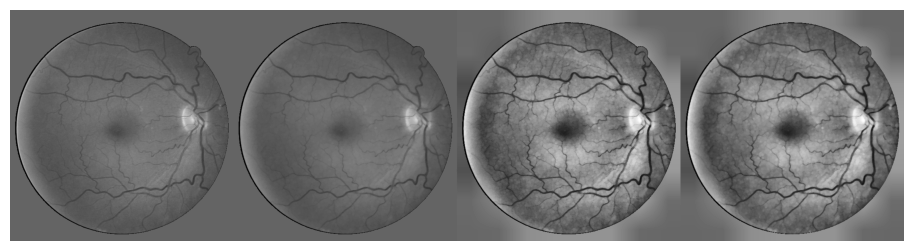

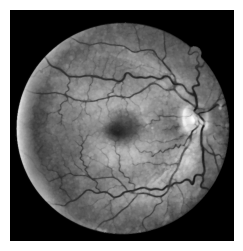

In [9]:
def PreProcess(image: np.ndarray, mask: np.ndarray, plot_image: bool):
    """
        Args:
            - image (np.ndarray): A 2D  array, shape (height, width).
            - mask (np.ndarray): A binary mask array, shape (height, width).
  
        Returns:
            - Processed Image (np.ndarray): A 2D array of the same shape as image.
  
        Steps:
            - Mask Adjustment:
            - Morphological Opening
            - Contrast Enhancement
            - Smoothing
  
  
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

    #first convert mask to binary mask
    index = mask == 255
    mask[index] = 1

    #replace zero masks with mean of the masked image
    masked_image = image * mask
    mean = np.mean(masked_image[masked_image > 0])
    index = mask == 0
    image[index] = mean

    SE = disk(2)
    #now perform steps mentioned in document : you can refer to :
    # https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html
    # https://docs.opencv.org/4.x/d6/db6/classcv_1_1CLAHE.html
    # https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9

    # opening = None
    # kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, SE)

    # clahe = None
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    # clh = None
    clh = clahe.apply(opening)
    # median = None
    median = cv2.medianBlur(clh, 3)

    #################################################################################

    if plot_image:
        plot_images([image, opening, clh, median])
    return np.multiply(median, mask)


test_img_preprocessed = PreProcess(test_img[:, :, 1], test_mask, plot_image=True)
plot_images([test_img_preprocessed])


## Feature Extraction (70 pts)

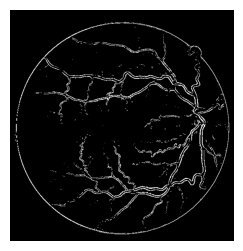

In [10]:
def Roberts_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

    # Roberts Edge Detection: The Roberts operator measures a 2-D spatial gradient on an image in a straightforward, quick-to-compute manner.

    # https://www.geeksforgeeks.org/python-opencv-roberts-edge-detection/ this link helped for implementation     

    image = image.astype('float64') / 255.0
    roberts_cross_v = np.array([[1, 0], [0, -1]])
    roberts_cross_h = np.array([[0, 1], [-1, 0]])

    vertical = ndimage.convolve(image, roberts_cross_v)
    horizontal = ndimage.convolve(image, roberts_cross_h)
    edged_img_sqrt = np.sqrt(np.square(vertical) + np.square(horizontal))
    edged_img = (edged_img_sqrt * 255).astype(np.uint8)
    _, edged_img = cv2.threshold(edged_img, 30, 255, cv2.THRESH_BINARY)
    # edged_img_thresh = edged_img >20

    # print(edged_img[200])

    #################################################################################
    return edged_img


test_edged_img = Roberts_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

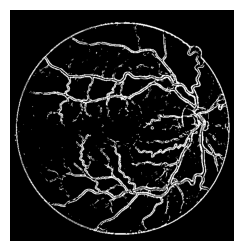

In [11]:
def Prewitt_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

    #Prewitt mask is a first-order derivative mask. In the graph representation of Prewitt-mask’s result, the edge is represented by the local maxima or local minima.
    kernelx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    kernely = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    image = image.astype('float64') / 255.0
    img_prewittx = ndimage.convolve(image, kernelx)
    img_prewitty = ndimage.convolve(image, kernely)
    edged_img_sqrt = np.sqrt(img_prewittx ** 2 + img_prewitty ** 2)
    edged_img = (edged_img_sqrt * 255).astype(np.uint8)
    _, edged_img = cv2.threshold(edged_img, 60, 255, cv2.THRESH_BINARY)

    #################################################################################
    return edged_img


test_edged_img = Prewitt_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

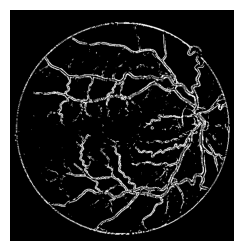

In [12]:
def Sobel_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

    #Prewitt mask is a first-order derivative mask. In the graph representation of Prewitt-mask’s result, the edge is represented by the local maxima or local minima.
    kernelx = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    kernely = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    image = image.astype('float64') / 255.0
    img_Sobelx = ndimage.convolve(image, kernelx)
    img_Sobely = ndimage.convolve(image, kernely)
    edged_img_sqrt = np.sqrt(np.square(img_Sobelx) + np.square(img_Sobely))
    edged_img = (edged_img_sqrt * 255).astype(np.uint8)
    _, edged_img = cv2.threshold(edged_img, 90, 255, cv2.THRESH_BINARY)

    #################################################################################
    return edged_img


test_edged_img = Sobel_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

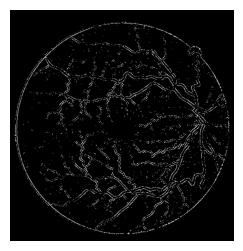

In [13]:
def LOG_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)

    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    blur = cv2.GaussianBlur(image, (3, 3), 2)

    LoG = cv2.Laplacian(blur, cv2.CV_64F, 3)

    # 
    # kernel = np.array([[0, 1, 0],
    #                    [1, 1, 1],
    #                    [0, 1,0]], dtype=np.uint8)
    kernel = np.ones((3, 3))

    minLoG = cv2.morphologyEx((LoG < -6).astype(np.uint8), cv2.MORPH_DILATE, kernel)
    maxLoG = cv2.morphologyEx((LoG > 6).astype(np.uint8), cv2.MORPH_DILATE, kernel)

    zeroCross = np.logical_or(
        np.logical_and(minLoG < 0, LoG > 0),
        np.logical_and(maxLoG > 0, LoG < 0)
    ).astype(np.uint8) * 255

    return zeroCross


# Example usage
test_edged_img = LOG_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])


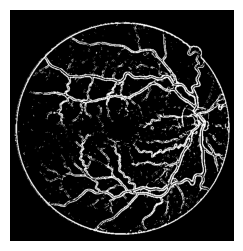

In [14]:
def Edge_Algorithm_features(image):
    """
      Extract edge features from a grayscale image using Roberts, Prewitt and LOG edge detection algorithms.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width)

      Returns:
          np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #
    #Roberts, Prewitt, Sobel, Canny, Log
    R = Roberts_Edge_Detection(image)
    P = Prewitt_Edge_Detection(image)
    S = Sobel_Edge_Detection(image)
    # _, S = None
    C = cv2.Canny(image, threshold1=100, threshold2=256)
    L = LOG_Edge_Detection(image)
    #################################################################################
    return R + P + S + C + L


test_edged_img = Edge_Algorithm_features(test_img_preprocessed)
plot_images([test_edged_img])

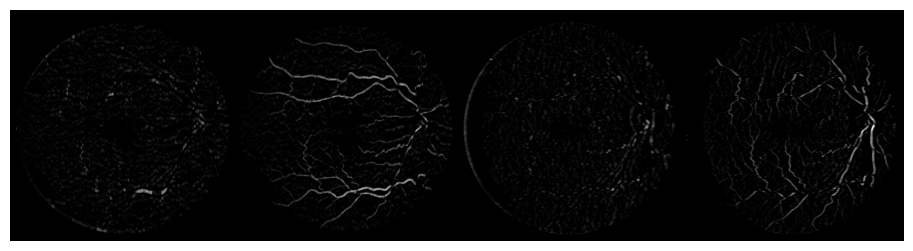

In [15]:
def Morphological_features(image):
    """
      Extract morphological features from a grayscale image using
      top-hat and black-hat morphological transformations.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width).

      Returns:
          tuple: A tuple containing four elements:
              - tophat_img (np.ndarray): The top-hat transformed image, highlighting
                bright features on a dark background.
              - bothat_img (np.ndarray): The black-hat transformed image, emphasizing
                dark features on a bright background.
              - tophat_img2 (np.ndarray): The second top-hat transformed image with
                a different structuring element orientation.
              - bothat_img2 (np.ndarray): The second black-hat transformed image with
                a different structuring element orientation.

    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #
    # kernel = np.ones((3, 3), np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 11))
    tophat_img = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    bothat_img = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)

    ######### new features added #################################
    # kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (11, 1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 1))
    tophat_img2 = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    bothat_img2 = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)
    #################################################################################
    return tophat_img, bothat_img, tophat_img2, bothat_img2


test_morph_image = Morphological_features(test_img_preprocessed)
plot_images(test_morph_image)


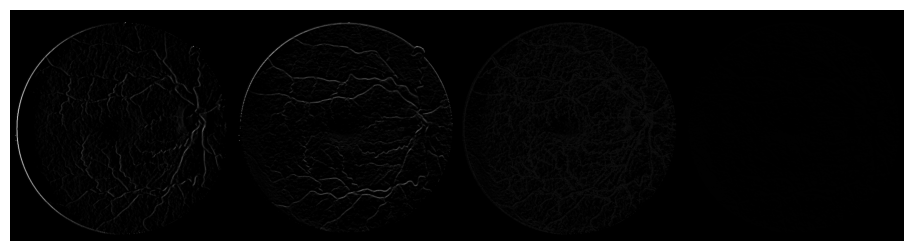

In [16]:
def Gradient_Based_features(image):
    """
        Calculate gradient-based features from a grayscale image using
        convolution with Sobel-like kernels.
  
        Args:
            image (np.ndarray): A 2D grayscale image array of shape (height, width).
  
  
        Returns:
            tuple: A tuple containing four elements:
                - Gx (np.ndarray): The gradient of the image in the x-direction.
                - Gy (np.ndarray): The gradient of the image in the y-direction.
                - M (np.ndarray): The magnitude of the gradient.
                - Theta (np.ndarray): The angle of the gradient direction.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

    kernel = np.ones((2, 2), np.uint8)
    dx_kernel = np.array([[-1, 1]])
    dy_kernel = np.array([[-1], [1]])
    Gx = cv2.morphologyEx(cv2.filter2D(image, -1, dx_kernel), cv2.MORPH_DILATE, kernel)
    Gy = cv2.morphologyEx(cv2.filter2D(image, -1, dy_kernel), cv2.MORPH_DILATE, kernel)
    M = np.sqrt(np.square(Gx) + np.square(Gy))
    Theta = np.arctan2(Gy, Gx)

    #################################################################################
    return Gx, Gy, M, Theta


test_gradient_image = Gradient_Based_features(test_img_preprocessed)
plot_images(test_gradient_image)


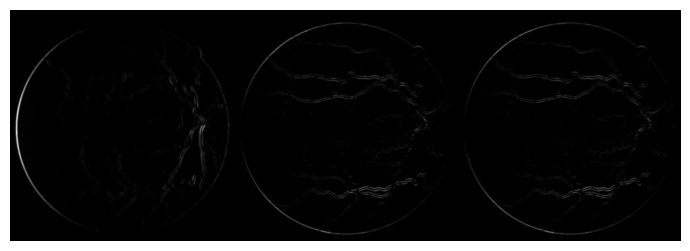

In [21]:
def Hessian_features(image):
    """
      Calculate Hessian matrix components for a given grayscale image
      to capture second-order derivative information for edge detection.
  
      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width).
  
      Returns:
          tuple: A tuple containing three elements:
              - Gxx (np.ndarray): The second derivative of the image with respect
                to the x-direction.
              - Gxy (np.ndarray): The mixed second derivative of the image with respect
                to both x and y directions.
              - Gyy (np.ndarray): The second derivative of the image with respect
                to the y-direction.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize =11)  # X edges
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize= 11)  # Y edges

    Gxx = ndimage.gaussian_filter(Ix** 2, 1, 0,)
    Gxy = ndimage.gaussian_filter(Iy ** 2, 0, 1)
    Gyy = ndimage.gaussian_filter(Iy ** 2 , 0, 1)
    # 
    # Gxx = cv2.Sobel(Ix, cv2.CV_64F, 1, 0, ksize=3)  
    # Gxy = cv2.Sobel(Ix, cv2.CV_64F, 0, 1, ksize=3)  
    # Gyy = cv2.Sobel(Iy, cv2.CV_64F, 0, 1, ksize=3)  

    return Gxx, Gxy, Gyy  #################################################################################


test_hessian_image = Hessian_features(test_img_preprocessed)
plot_images(test_hessian_image)

In [22]:
def Statistical_features(image, index):
    """
    Compute statistical features from a given grayscale image.

    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width).
        index (tuple(np.ndarray,np.ndarray)): A tuple of two vector which contains x and y coordinates of non-zero pixels
    Returns:
        np.ndarray: A 3D array of shape (height, width, 8) containing the following
                    statistical features for each pixel:
                    - Mean
                    - Minimum
                    - Maximum
                    - Skewness
                    - Kurtosis
                    - Standard Deviation
                    - Mean Absolute Deviation
                    - Root Sum of Squared Levels
    """

    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

    # Mean, Minimum, Maximum, Skewness, Kurtosis, Standard deviation,
    # Mean absolute deviation, Root sum of squared level, size = 21
    k = 10
    img = cv2.copyMakeBorder(image, k, k, k, k, cv2.BORDER_CONSTANT, None, image.mean())
    # print(image.shape, img.shape)
    # print(index)
    output = np.zeros((image.shape[0], image.shape[1], 8))
    X, Y = index

    for idx in tqdm(range(len(index[0]))):
        i = X[idx] + k
        j = Y[idx] + k
        cur_patch = img[i - k:i + k + 1, j - k: j + k + 1].flatten()
        output[i - 2 * k, j - 2 * k, 0] = np.mean(cur_patch)  #mean
        output[i - 2 * k, j - 2 * k, 1] = np.min(cur_patch)  #min
        output[i - 2 * k, j - 2 * k, 2] = np.max(cur_patch)  #max
        output[i - 2 * k, j - 2 * k, 3] = skew(cur_patch)  #skew
        output[i - 2 * k, j - 2 * k, 4] = kurtosis(cur_patch)  #kurtosis
        output[i - 2 * k, j - 2 * k, 5] = np.std(cur_patch)  #std
        output[i - 2 * k, j - 2 * k, 6] = np.mean(np.abs(cur_patch - np.mean(cur_patch)))  #mean absolute deviation
        output[i - 2 * k, j - 2 * k, 7] = np.sqrt(np.sum(cur_patch ** 2))  #root sum of squared level

    #################################################################################
    return [stat for stat in output[:, :]]


In [23]:
index = np.where(test_mask != 0)
print(test_mask.shape)
test_statistic_features = Statistical_features(test_img_preprocessed, index)
mean, min, max, Skewness, Kurtosis, std, mad, sqrt = np.transpose(test_statistic_features, (2, 0, 1))[:]
test_statistic_features = np.stack(
    (mean[index], min[index], max[index], Skewness[index], Kurtosis[index], std[index], mad[index], sqrt[index]),
    axis=1)
data = pd.DataFrame()
df = pd.DataFrame(test_statistic_features)
df

(584, 565)


100%|██████████| 227686/227686 [01:23<00:00, 2710.81it/s]


0    1      2         3         4          5          6  \
0       79.455782  0.0  139.0 -2.301267  4.642578  22.935945  14.583121   
1       79.544218  0.0  139.0 -2.325725  4.805459  22.786368  14.473568   
2       79.614512  0.0  139.0 -2.335677  4.897703  22.692985  14.440208   
3       79.666667  0.0  139.0 -2.331457  4.912113  22.666367  14.467120   
4       79.657596  0.0  139.0 -2.319268  4.885009  22.664631  14.502188   
...           ...  ...    ...       ...       ...        ...        ...   
227681   0.000000  0.0    0.0  0.000000  0.000000   0.000000   0.000000   
227682   0.000000  0.0    0.0  0.000000  0.000000   0.000000   0.000000   
227683   0.000000  0.0    0.0  0.000000  0.000000   0.000000   0.000000   
227684   0.000000  0.0    0.0  0.000000  0.000000   0.000000   0.000000   
227685   0.000000  0.0    0.0  0.000000  0.000000   0.000000   0.000000   

                 7  
0       247.729691  
1       247.440902  
2       245.340580  
3       244.415630  
4       243.563133  
...            ...  
227681    0.000000  
227682    0.000000  
227683    0.000000  
227684    0.000000  
227685    0.000000  

[227686 rows x 8 columns]



1. **Setup Paths**: Defines paths for images, masks, and labels from the DRIVE dataset.
   
2. **Load File Lists**: Retrieves and sorts the filenames for images, masks, and labels from the specified directories.

3. **Initialize DataFrame**: Creates an empty DataFrame to store the extracted features from each processed image.

4. **Image Processing Loop**: Iterates over the first 20 images:
   - Reads each image and its corresponding mask and label.
   - Reshapes the mask and label arrays to standard dimensions.
   - Converts label values from 255 to 1 for binary representation.
   - Applies preprocessing to the image using the `PreProcess` function.

5. **Feature Extraction**: Extracts various features from the preprocessed image:
   - Edge features using the `Edge_Algorithm_features` function.
   - Morphological features using the `Morphological_features` function.
   - Statistical features (mean, min, max, skewness, kurtosis, standard deviation, mean absolute deviation, and root sum of squares) using the `Statistical_features` function.
   - Gradient-based features (Gx, Gy, magnitude, and angle) using the `Gradient_Based_features` function.
   - Hessian features using the `Hessian_features` function.

6. **Feature Compilation**: Stacks the extracted features along with the corresponding label and creates a DataFrame from the features.

7. **Data Storage**: Concatenates the newly created DataFrame with the main DataFrame to accumulate all extracted features.

This step prepares the data for  model training.



In [77]:

train_image_path = 'DRIVE/Training/images/'
train_mask_path = 'DRIVE/Training/mask/'
train_label_path = 'DRIVE/Training/1st_manual/'

test_image_path = 'DRIVE/Test/images/'
test_mask_path = 'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'


def extract_features(image_path, mask_path, label_path):
    images = [f for f in listdir(image_path) if isfile(join(image_path, f))]
    images.sort()
    masks = [f for f in listdir(mask_path) if isfile(join(mask_path, f))]
    masks.sort()
    labels = [f for f in listdir(label_path) if isfile(join(label_path, f))]
    labels.sort()
    data = pd.DataFrame()
    for i in tqdm(range(len(images))):
        image = cv2.imread(join(image_path, images[i]))
        mask = np.array(imageio.mimread(join(mask_path, masks[i]))).reshape(584, 565)
        label = np.array(imageio.mimread(join(label_path, labels[i]))).reshape(584, 565)
        label[np.where(label == 255)] = 1
        index = np.where(mask != 0)
        image = PreProcess(image[:, :, 1], mask, False)

        ################# feature extraction######################################

        edges = Edge_Algorithm_features(image)
        (tophat, bothat, tophat2, bothat2) = Morphological_features(image)
        mean, min, max, Skewness, Kurtosis, std, mad, sqrt = np.transpose(Statistical_features(image, index),
                                                                          (2, 0, 1))[:]
        (Gx, Gy, M, Theta) = Gradient_Based_features(image)
        (Gxx, Gxy, Gyy) = Hessian_features(image)
        features = np.stack(
            (edges[index], tophat[index], bothat[index], Gx[index], Gy[index], tophat2[index], bothat2[index],
             mean[index], min[index], max[index], Skewness[index], Kurtosis[index], std[index], mad[index], sqrt[index],
             M[index], Theta[index], Gxx[index], Gxy[index], Gyy[index], label[index]), axis=1)

        df = pd.DataFrame(features)
        data = pd.concat([data, df])
    return data


df_train = extract_features(train_image_path, train_mask_path, train_label_path)
df_test = extract_features(test_image_path, test_mask_path, test_label_path)


  0%|          | 0/20 [00:00<?, ?it/s]

(584, 565) (604, 585)



  5%|▌         | 1/20 [01:26<27:24, 86.55s/it]

(584, 565) (604, 585)



 10%|█         | 2/20 [02:48<25:13, 84.08s/it]

(584, 565) (604, 585)



 15%|█▌        | 3/20 [04:11<23:38, 83.43s/it]

(584, 565) (604, 585)



 20%|██        | 4/20 [05:37<22:31, 84.46s/it]

(584, 565) (604, 585)



 25%|██▌       | 5/20 [07:01<21:01, 84.12s/it]

(584, 565) (604, 585)



 30%|███       | 6/20 [08:23<19:29, 83.56s/it]

(584, 565) (604, 585)



 35%|███▌      | 7/20 [09:47<18:08, 83.73s/it]

(584, 565) (604, 585)



 40%|████      | 8/20 [11:14<16:55, 84.59s/it]

(584, 565) (604, 585)



 45%|████▌     | 9/20 [12:41<15:39, 85.44s/it]

(584, 565) (604, 585)



 50%|█████     | 10/20 [14:08<14:20, 86.03s/it]

(584, 565) (604, 585)



 55%|█████▌    | 11/20 [15:32<12:47, 85.24s/it]

(584, 565) (604, 585)



 60%|██████    | 12/20 [16:50<11:04, 83.06s/it]

(584, 565) (604, 585)



 65%|██████▌   | 13/20 [18:11<09:36, 82.43s/it]

(584, 565) (604, 585)



 70%|███████   | 14/20 [19:30<08:09, 81.53s/it]

(584, 565) (604, 585)



 75%|███████▌  | 15/20 [20:50<06:45, 81.05s/it]

(584, 565) (604, 585)



 80%|████████  | 16/20 [22:16<05:29, 82.35s/it]

(584, 565) (604, 585)



 85%|████████▌ | 17/20 [23:39<04:07, 82.61s/it]

(584, 565) (604, 585)



 90%|█████████ | 18/20 [24:59<02:44, 82.03s/it]

(584, 565) (604, 585)



 95%|█████████▌| 19/20 [26:20<01:21, 81.50s/it]

(584, 565) (604, 585)



  0%|          | 0/20 [00:00<?, ?it/s]

(584, 565) (604, 585)



  5%|▌         | 1/20 [01:24<26:47, 84.63s/it]

(584, 565) (604, 585)



 10%|█         | 2/20 [02:49<25:27, 84.84s/it]

(584, 565) (604, 585)



 15%|█▌        | 3/20 [04:13<23:55, 84.43s/it]

(584, 565) (604, 585)



 20%|██        | 4/20 [05:36<22:18, 83.66s/it]

(584, 565) (604, 585)



 25%|██▌       | 5/20 [06:58<20:50, 83.37s/it]

(584, 565) (604, 585)



 30%|███       | 6/20 [08:19<19:14, 82.44s/it]

(584, 565) (604, 585)



 35%|███▌      | 7/20 [09:40<17:46, 82.02s/it]

(584, 565) (604, 585)



 40%|████      | 8/20 [11:00<16:17, 81.46s/it]

(584, 565) (604, 585)



 45%|████▌     | 9/20 [12:22<14:56, 81.46s/it]

(584, 565) (604, 585)



 50%|█████     | 10/20 [13:43<13:34, 81.43s/it]

(584, 565) (604, 585)



 55%|█████▌    | 11/20 [15:04<12:10, 81.19s/it]

(584, 565) (604, 585)



 60%|██████    | 12/20 [16:24<10:47, 80.97s/it]

(584, 565) (604, 585)



 65%|██████▌   | 13/20 [17:47<09:29, 81.38s/it]

(584, 565) (604, 585)



 70%|███████   | 14/20 [19:06<08:05, 80.88s/it]

(584, 565) (604, 585)



 75%|███████▌  | 15/20 [20:26<06:42, 80.53s/it]

(584, 565) (604, 585)



 80%|████████  | 16/20 [21:45<05:20, 80.09s/it]

(584, 565) (604, 585)



 85%|████████▌ | 17/20 [23:04<03:59, 79.71s/it]

(584, 565) (604, 585)



 90%|█████████ | 18/20 [24:23<02:38, 79.40s/it]

(584, 565) (604, 585)



 95%|█████████▌| 19/20 [25:42<01:19, 79.27s/it]

(584, 565) (604, 585)



100%|██████████| 20/20 [27:00<00:00, 81.05s/it]


In [78]:
df_train.to_csv("train.csv")
df_test.to_csv("test.csv")



In [24]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [25]:
df_train

Unnamed: 0      0     1    2      3     4      5    6           7  \
0                 0  255.0   0.0  0.0   50.0  50.0    0.0  0.0  121.668934   
1                 1  254.0   0.0  0.0   50.0  50.0    0.0  0.0  121.664399   
2                 2  254.0   0.0  0.0    6.0  56.0    0.0  0.0  121.621315   
3                 3  254.0   0.0  0.0   10.0  66.0    3.0  0.0  121.573696   
4                 4  255.0   0.0  0.0   10.0  66.0    3.0  0.0  121.546485   
...             ...    ...   ...  ...    ...   ...    ...  ...         ...   
4541001      226969  253.0   0.0  0.0    2.0   0.0   25.0  0.0    0.000000   
4541002      226970  253.0   0.0  0.0    1.0   0.0   25.0  0.0    0.000000   
4541003      226971  253.0   0.0  0.0    0.0   0.0   25.0  0.0    0.000000   
4541004      226972  253.0   0.0  0.0    0.0   0.0   25.0  0.0    0.000000   
4541005      226973  253.0  96.0  0.0  140.0  96.0  140.0  0.0    0.000000   

            8  ...        11         12         13          14         15  \
0        50.0  ...  2.042596  21.807947  15.710254  174.774140  11.664062   
1         0.0  ...  3.350124  22.122537  15.748531  177.611937  11.664062   
2         0.0  ...  4.473144  22.452558  15.822605  179.963885  10.000000   
3         0.0  ...  5.440780  22.876473  15.957405  184.287818  10.195312   
4         0.0  ...  6.199041  23.416823  16.139088  188.880915  10.195312   
...       ...  ...       ...        ...        ...         ...        ...   
4541001   0.0  ...  0.000000   0.000000   0.000000    0.000000   2.000000   
4541002   0.0  ...  0.000000   0.000000   0.000000    0.000000   1.000000   
4541003   0.0  ...  0.000000   0.000000   0.000000    0.000000   0.000000   
4541004   0.0  ...  0.000000   0.000000   0.000000    0.000000   0.000000   
4541005   0.0  ...  0.000000   0.000000   0.000000    0.000000  12.000000   

               16         17     18     19   20  
0        0.785156  -3.064630  284.0  284.0  0.0  
1        0.785156  12.139668  206.0  206.0  0.0  
2        1.463867  22.564746  228.0  228.0  0.0  
3        1.420898  18.278188  254.0  254.0  0.0  
4        1.420898   6.960037  264.0  264.0  0.0  
...           ...        ...    ...    ...  ...  
4541001  0.000000   2.463008  -99.0  -99.0  0.0  
4541002  0.000000  -0.247133 -100.0 -100.0  0.0  
4541003  0.000000  -4.793380 -100.0 -100.0  0.0  
4541004  0.000000  -9.129918 -116.0 -116.0  0.0  
4541005  0.601074  -4.668205 -169.0 -169.0  0.0  

[4541006 rows x 22 columns]

In [26]:
df_test

Unnamed: 0      0     1    2      3      4     5    6           7  \
0                 0  252.0  22.0  0.0  122.0  122.0  35.0  0.0  104.582766   
1                 1  253.0   0.0  0.0  122.0  122.0   8.0  7.0  104.378685   
2                 2  254.0   0.0  0.0    0.0   95.0   8.0  7.0  104.383220   
3                 3  254.0   0.0  0.0    6.0  101.0  14.0  1.0  104.458050   
4                 4  255.0   0.0  0.0    6.0  101.0  14.0  1.0  104.625850   
...             ...    ...   ...  ...    ...    ...   ...  ...         ...   
4538138      227518  253.0   0.0  0.0   34.0    0.0  34.0  6.0    0.000000   
4538139      227519  253.0   0.0  0.0    5.0    0.0  39.0  1.0    0.000000   
4538140      227520  253.0   0.0  0.0    5.0    0.0  40.0  0.0    0.000000   
4538141      227521  253.0   0.0  0.0    1.0    0.0  40.0  0.0    0.000000   
4538142      227522  253.0   0.0  0.0    0.0    0.0  40.0  0.0    0.000000   

            8  ...        11        12        13          14         15  \
0        84.0  ... -0.206310  9.273035  7.091006  223.872732   8.484375   
1        84.0  ... -0.353461  9.390225  7.345345  228.571652   8.484375   
2        84.0  ... -0.443721  9.502146  7.539441  232.609114   8.062500   
3        84.0  ... -0.495333  9.571485  7.680421  235.452755  15.906250   
4        84.0  ... -0.545283  9.652143  7.844787  235.512208  15.906250   
...       ...  ...       ...       ...       ...         ...        ...   
4538138   0.0  ...  0.000000  0.000000  0.000000    0.000000  11.492188   
4538139   0.0  ...  0.000000  0.000000  0.000000    0.000000   5.000000   
4538140   0.0  ...  0.000000  0.000000  0.000000    0.000000   5.000000   
4538141   0.0  ...  0.000000  0.000000  0.000000    0.000000   1.000000   
4538142   0.0  ...  0.000000  0.000000  0.000000    0.000000   0.000000   

               16         17     18     19   20  
0        0.785156  58.166825  425.0  425.0  0.0  
1        0.785156  16.053693  389.0  389.0  0.0  
2        1.570312   3.939963  386.0  386.0  0.0  
3        1.511719   6.973757  398.0  398.0  0.0  
4        1.511719   4.489567  404.0  404.0  0.0  
...           ...        ...    ...    ...  ...  
4538138  0.000000   8.448965 -141.0 -141.0  0.0  
4538139  0.000000  11.866652 -152.0 -152.0  0.0  
4538140  0.000000   9.275998 -159.0 -159.0  0.0  
4538141  0.000000  11.228898 -160.0 -160.0  0.0  
4538142  0.000000  16.597820 -241.0 -241.0  0.0  

[4538143 rows x 22 columns]

## Training Phase (18 pts)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

- **Note**: Due to the significant differences in the scale of the extracted features, the values should normalize before training the neural network.


In [28]:
sc = StandardScaler()

shuffled = df_train.sample(frac=1)
X_train = sc.fit_transform(shuffled.iloc[:, 1:21])
Y_train = shuffled.iloc[:, -1].astype(int).to_numpy()

X_test = sc.fit_transform(df_test.iloc[:, 1:21])
Y_test = df_test.iloc[:, -1].astype(int).to_numpy()

- **Note**: Since the number of foreground pixels is much smaller than the background pixels, a weighted binary cross-entropy loss is used, with a higher weight assigned to errors in detecting blood vessels.(9pt)

In [29]:

class MyDataset(Dataset):

    def __init__(self, X, Y):
        self.x_train = torch.tensor(X, dtype=torch.float32)
        self.y_train = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(20, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc4(x))
        return torch.sigmoid(self.fc3(x))


class weighted_binary_cross_entropy(nn.Module):
    def __init__(self):
        super(weighted_binary_cross_entropy, self).__init__()

    def forward(self, output, target, weights=None):
        output = torch.clamp(output, min=1e-8, max=1 - 1e-8)

        if weights is not None:
            assert len(weights) == 2
            #################################################################################
            #                         YOUR CODE GOES HERE                                   #
            #implement weighted cross entropy loss
            loss = weights[1] * target * torch.log(output) + weights[0] * (1 - target) * torch.log(1 - output)
        else:
            loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

        return torch.neg(torch.mean(loss))

In [30]:
#####################################
###### DO NOT CHANGE THIS CELL ######
#####################################

N_EPOCHS = 20
BATCH_SIZE = 128
LR = 1e-2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(MyDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=False)
model = Classifier().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = weighted_binary_cross_entropy()

- After generating the probability of each pixel being part of a blood vessel. A fixed threshold of `0.4` should choose to binarize these values.

In [31]:
# training loop
def train_model(model, train_dataloader, n_epochs, optimizer, criterion, device):
    model.train()
    train_losses = []
    train_accuracies = []
    for epoch in tqdm(range(n_epochs)):
        #################################################################################
        #                         YOUR CODE GOES HERE                                   #

        epoch_loss = 0
        correct = 0
        total = 0
        for data, target in train_dataloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            output = output.reshape(target.shape)
            loss = criterion(output, target, [1, 1.2])
            loss.backward()
            optimizer.step()

            predicted = output >= 0.45
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            epoch_loss += loss.item()

        accu = 100.0 * correct / total
        train_loss = epoch_loss / len(train_loader)
        train_accuracies.append(accu)
        train_losses.append(train_loss)

        #################################################################################
        print('Epoch: {}  Train Loss: {:.4f}  Accuracy: {:.3f}'.format(epoch + 1, train_loss, accu))

    return model, train_losses, train_accuracies


In [32]:
trained_model, train_losses, train_accuracies = train_model(model, train_loader, N_EPOCHS, optimizer, criterion, DEVICE)

  5%|▌         | 1/20 [00:41<13:07, 41.44s/it]

Epoch: 1  Train Loss: 0.2146  Accuracy: 92.868


 10%|█         | 2/20 [01:20<12:01, 40.10s/it]

Epoch: 2  Train Loss: 0.2042  Accuracy: 93.213


 15%|█▌        | 3/20 [02:02<11:35, 40.91s/it]

Epoch: 3  Train Loss: 0.2011  Accuracy: 93.339


 20%|██        | 4/20 [02:40<10:34, 39.65s/it]

Epoch: 4  Train Loss: 0.1995  Accuracy: 93.389


 25%|██▌       | 5/20 [03:17<09:43, 38.89s/it]

Epoch: 5  Train Loss: 0.1984  Accuracy: 93.424


 30%|███       | 6/20 [03:55<09:00, 38.58s/it]

Epoch: 6  Train Loss: 0.1976  Accuracy: 93.448


 35%|███▌      | 7/20 [04:35<08:27, 39.07s/it]

Epoch: 7  Train Loss: 0.1969  Accuracy: 93.469


 40%|████      | 8/20 [05:14<07:48, 39.02s/it]

Epoch: 8  Train Loss: 0.1964  Accuracy: 93.487


 45%|████▌     | 9/20 [06:05<07:51, 42.83s/it]

Epoch: 9  Train Loss: 0.1960  Accuracy: 93.501


 50%|█████     | 10/20 [06:44<06:55, 41.52s/it]

Epoch: 10  Train Loss: 0.1956  Accuracy: 93.511


 55%|█████▌    | 11/20 [07:22<06:02, 40.32s/it]

Epoch: 11  Train Loss: 0.1953  Accuracy: 93.521


 60%|██████    | 12/20 [07:59<05:16, 39.54s/it]

Epoch: 12  Train Loss: 0.1950  Accuracy: 93.530


 65%|██████▌   | 13/20 [08:36<04:31, 38.79s/it]

Epoch: 13  Train Loss: 0.1948  Accuracy: 93.539


 70%|███████   | 14/20 [09:13<03:49, 38.22s/it]

Epoch: 14  Train Loss: 0.1946  Accuracy: 93.546


 75%|███████▌  | 15/20 [09:50<03:09, 37.86s/it]

Epoch: 15  Train Loss: 0.1945  Accuracy: 93.551


 80%|████████  | 16/20 [10:29<02:32, 38.03s/it]

Epoch: 16  Train Loss: 0.1943  Accuracy: 93.556


 85%|████████▌ | 17/20 [11:08<01:54, 38.27s/it]

Epoch: 17  Train Loss: 0.1942  Accuracy: 93.561


 90%|█████████ | 18/20 [11:47<01:17, 38.76s/it]

Epoch: 18  Train Loss: 0.1941  Accuracy: 93.565


 95%|█████████▌| 19/20 [12:27<00:38, 38.87s/it]

Epoch: 19  Train Loss: 0.1939  Accuracy: 93.569


100%|██████████| 20/20 [13:05<00:00, 39.28s/it]

Epoch: 20  Train Loss: 0.1938  Accuracy: 93.573


--------------
In order to `evaluate` the method, three metrics will be used: accuracy, specificity, and sensitivity, each of which is defined as follows:

First, we define the parameters TP, TN, FP, and FN, which will be used to calculate the mentioned metrics.

`TP`: The number of pixels that are part of the vessel, and the method also correctly identifies them as vessels.

`TN`: The number of pixels that belong to the background, and the method also correctly identifies them as background.

`FP`: The number of pixels that belong to the background, but the method incorrectly identifies them as vessels.

`FN`: The number of pixels that are part of the vessel, but the method incorrectly identifies them as background.

With these definitions in place, the three metrics are defined as follows:


$
\text{Sensitivity} = \frac{TP}{TP + FN}
$


$
\text{Specificity} = \frac{TN}{TN + FP}
$


$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$


In [33]:
def evaluation(image, label, mask):
    TP = TN = FP = FN = 0
    row, col = image.shape
    for i in range(row):
        for j in range(col):

            # if mask[i, j] != 0:
            p = image[i, j]
            l = label[i, j]
            if p != 0 and l != 0:
                TP += 1
            elif p != 0 and l == 0:
                FP += 1
            elif p == 0 and l == 0:
                TN += 1
            elif p == 0 and l != 0:
                FN += 1

    Sn = TP / (TP + FN)
    Sp = TN / (TN + FP)
    Acc = (TP + TN) / (TP + TN + FP + FN)

    return Sn, Sp, Acc

-----
- `Note`: you must reach at least `70%` sensitivity, `90%` specificity, and `90%` accuracy. (3 pts)


In [41]:
test_image_path = 'DRIVE/Test/images/'
test_mask_path = 'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'

images = [f for f in listdir(test_image_path) if isfile(join(test_image_path, f))]
images.sort()

masks = [f for f in listdir(test_mask_path) if isfile(join(test_mask_path, f))]
masks.sort()

labels = [f for f in listdir(test_label_path) if isfile(join(test_label_path, f))]
labels.sort()

sum = 0
cnt = 0
sn = sp = acc = 0

storage = []


for i in tqdm(range(len(images))):
    image = cv2.imread(join(test_image_path, images[i]))
    mask = np.array(imageio.mimread(join(test_mask_path, masks[i]))).reshape(584, 565)
    label = np.array(imageio.mimread(join(test_label_path, labels[i]))).reshape(584, 565)
    label[np.where(label == 255)] = 1
    index = np.where(mask != 0)
    cnt = index[0].shape[0]

    temp = np.zeros((584, 565))
    X = torch.from_numpy(X_test[sum:sum + cnt, :]).to(DEVICE)
    Y = Y_test[sum:sum + cnt]

    out = model(X.float()).reshape(Y.shape) >= 0.4

    x, y = index
    for idx in range(cnt, ):
        m = x[idx]
        n = y[idx]

        if out[idx] == 1:
            temp[m, n] = 255

    sum += cnt

    ########## for removing borders of mask ##############
    border = LOG_Edge_Detection(mask)
    kernel = np.ones((4, 4), np.uint8)
    border = cv2.dilate(border.astype('uint8'), kernel, iterations=1)
    idx = np.where(border != 0)
    temp[idx] = 0

    SN, SP, ACC = evaluation(temp, label, mask)

    sn += SN
    sp += SP
    acc += ACC
    storage.append((image, label, temp))

print(sn / len(images))
print(sp / len(images))
print(acc / len(images))15

100%|██████████| 20/20 [00:58<00:00,  2.92s/it]

0.7103927081289718
0.9803900149288729
0.9566123166444418


- Show two sample images along with their ground truth and the model output at the end. (6 pts)

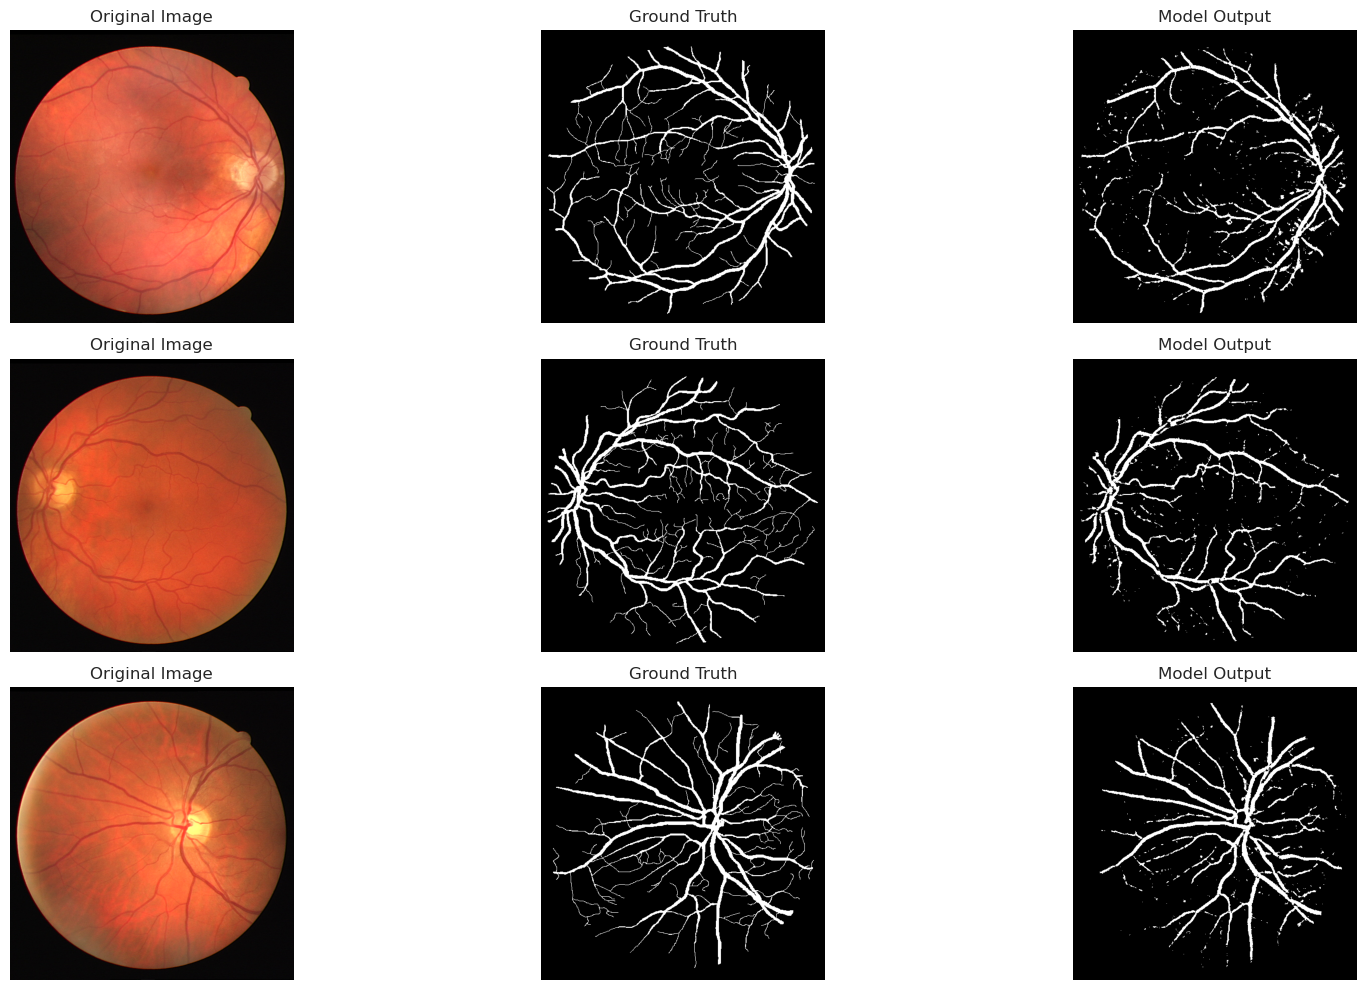

In [46]:
#################################################################################
#                         YOUR CODE GOES HERE       
#                    

n_samples = 3
random_indices = random.sample(range(len(storage)), n_samples)

fig, axs = plt.subplots(n_samples, 3, figsize=(18, 10))
for i, idx in enumerate(random_indices):
    axs[i, 0].imshow(cv2.cvtColor(storage[idx][0], cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(storage[idx][1], cmap='gray')
    axs[i, 1].set_title('Ground Truth')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(storage[idx][2], cmap='gray')
    axs[i, 2].set_title('Model Output')
    axs[i, 2].axis('off')
    
plt.tight_layout()
plt.show()
